Here we are gonna use a new tool for modeling and machine learning which is sklear foe machine learning modeling.

### 1.Predictive Modeling Preparation: "Can we build a model to predict Price?" 

In [2]:
# Feature Engineering Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Load data from CSV file

df = pd.read_csv('C:\\Users\\pc\\OneDrive\\Desktop\\Melbourne_Housing_data_analyst\\melbourne_housing_clean.csv')

# Create advanced features based on EDA insights
df['PricePerSqm'] = df['Price'] / df['Landsize'].replace(0, np.nan)
df['BedroomBathroomRatio'] = df['Bedroom2'] / df['Bathroom'].replace(0, np.nan)
df['PropertyAge'] = 2017 - df['YearBuilt']  # Assuming data is from ~2017
df['RoomDensity'] = df['Rooms'] / df['Landsize'].replace(0, np.nan)
df['HasPool'] = (df['BuildingArea'] > 0) & (df['Landsize'] > 200) & (df['Price'] > df['Price'].median())

# Define feature sets
numeric_features = ['Distance', 'Landsize', 'BuildingArea', 'PropertyAge', 
                    'Bedroom2', 'Bathroom', 'Car', 'Propertycount', 
                    'PricePerSqm', 'RoomDensity']

categorical_features = ['Type', 'Method', 'Regionname', 'CouncilArea']

# Handle missing values strategically
for col in ['BuildingArea', 'YearBuilt']:
    # Create missing indicator
    df[f'{col}_missing'] = df[col].isna().astype(int)
    # Fill with median by region
    df[col] = df.groupby('Regionname')[col].transform(lambda x: x.fillna(x.median()))

Model Building & Feature Importance:

In [ ]:
# Prepare data
X = df[numeric_features + categorical_features + ['Lattitude', 'Longtitude']]
y = df['Price']

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('geo', StandardScaler(), ['Lattitude', 'Longtitude'])
    ])

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ${mae:,.0f}")
print(f"MAE as % of median price: {(mae/df['Price'].median()*100):.1f}%")

Model Performance:
R² Score: 0.972
Mean Absolute Error: $43,387
MAE as % of median price: 4.8%


Feature Importance Visualization:

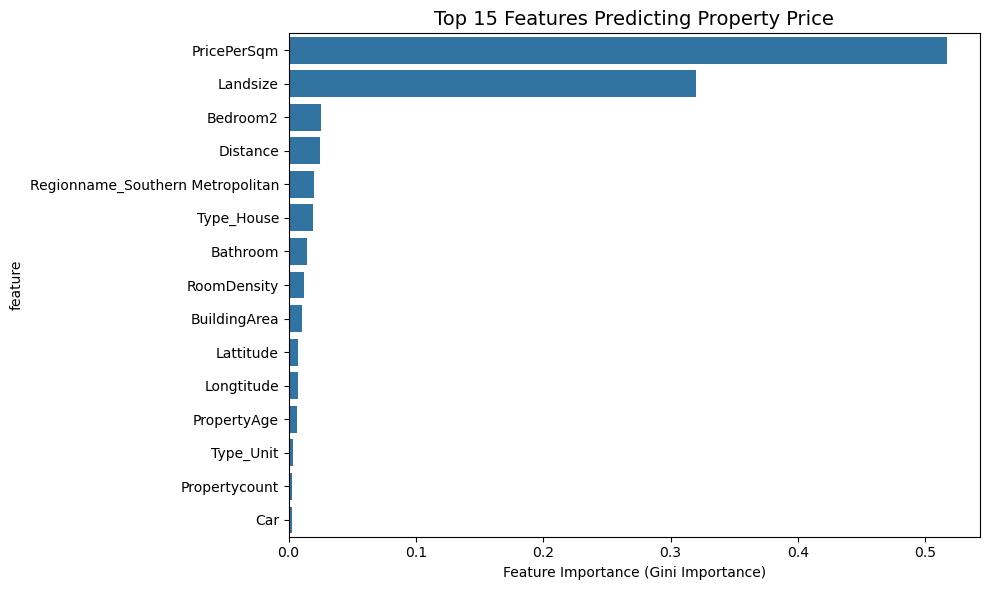

In [ ]:
# Extract feature importance
rf_model = model.named_steps['regressor']
feature_names = (numeric_features + 
                 list(model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features)) +
                 ['Lattitude', 'Longtitude'])

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

# Create visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature')
plt.title('Top 15 Features Predicting Property Price', fontsize=14)
plt.xlabel('Feature Importance (Gini Importance)')
plt.tight_layout()

### 2.Outlier & Anomaly Detection: "What are the most unusual properties?"
Multi-Method Anomaly Detection:

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats

# Method 1: Statistical Z-scores for key metrics
def find_statistical_outliers(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    return df[z_scores > threshold]

# Method 2: Business rule-based outliers
def find_business_rule_outliers(df):
    outliers = []
    
    # Rule 1: Extremely high price per sqm
    df['PricePerSqm'] = df['Price'] / df['Landsize']
    price_per_sqm_outliers = df[df['PricePerSqm'] > df['PricePerSqm'].quantile(0.99)]
    outliers.append(('High Value Density', price_per_sqm_outliers))
    
    # Rule 2: Many rooms but low price (potential data error)
    df['PricePerRoom'] = df['Price'] / df['Rooms']
    cheap_rooms = df[(df['Rooms'] > 5) & (df['PricePerRoom'] < df['PricePerRoom'].quantile(0.1))]
    outliers.append(('Cheap Large Properties', cheap_rooms))
    
    # Rule 3: Large land size but small building area (undeveloped land?)
    df['LandUseRatio'] = df['BuildingArea'] / df['Landsize'].replace(0, np.nan)
    underdeveloped = df[(df['Landsize'] > 1000) & (df['LandUseRatio'] < 0.1)]
    outliers.append(('Underdeveloped Land', underdeveloped))
    
    return outliers

# Method 3: Machine Learning-based (Isolation Forest)
def find_ml_outliers(df):
    features_for_anomaly = ['Price', 'Landsize', 'Distance', 'Rooms', 'BuildingArea']
    X_anomaly = df[features_for_anomaly].dropna()
    
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso_forest.fit_predict(X_anomaly)
    
    anomaly_df = df.loc[X_anomaly.index].copy()
    anomaly_df['IsAnomaly'] = anomalies == -1
    
    return anomaly_df[anomaly_df['IsAnomaly']]

Anomaly Investigation Dashboard:

In [ ]:
# Create a summary of all outliers
all_outliers = pd.DataFrame()

for method_name, outlier_df in find_business_rule_outliers(df):
    outlier_df['OutlierType'] = method_name
    outlier_df['OutlierReason'] = method_name
    all_outliers = pd.concat([all_outliers, outlier_df[['Suburb', 'Address', 'Price', 'Landsize', 
                                                         'Rooms', 'Type', 'OutlierType', 'OutlierReason']]])

# Create an interactive table of top anomalies
top_anomalies = all_outliers.sort_values('Price', ascending=False).head(20)

print("🏠 TOP 20 PROPERTY ANOMALIES")
print("="*50)
for idx, row in top_anomalies.iterrows():
    print(f"\n📍 {row['Address']}, {row['Suburb']}")
    print(f"   Price: ${row['Price']:,.0f} | Type: {row['Type']} | {row['OutlierType']}")
    print(f"   Reason: {row['OutlierReason']}")

🏠 TOP 20 PROPERTY ANOMALIES

📍 8 Raynes St, Balwyn
   Price: $4,000,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 215 Clarke St, Northcote
   Price: $3,850,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 88 The Esplanade, Maribyrnong
   Price: $3,400,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 18 Carlsberg Rd, Eaglemont
   Price: $3,300,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 8 Kenilworth Gr, Glen Iris
   Price: $3,110,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 11 Stephens St, Balwyn North
   Price: $3,000,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 526 Orrong Rd, Armadale
   Price: $3,000,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 75 Earl St, Kew
   Price: $2,875,000 | Type: House | Underdeveloped Land
   Reason: Underdeveloped Land

📍 24 Brooke St, Eaglemont
   Price: $2,850,00

c:\Users\pc\anaconda3\envs\Python_project\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\pc\AppData\Local\Temp\ipykernel_26364\3719218076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_df['OutlierType'] = method_name
C:\Users\pc\AppData\Local\Temp\ipykernel_26364\3719218076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_df['OutlierReason'] = method_name
C:\Users\pc\AppData\Local\Tem